## Performing Spatial Joins in Python
Some great introduction text goes here

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import dask_geopandas
import dask.dataframe as dd
from shapely.geometry import Point

In [2]:
# import coiled
 
# coiled.create_software_environment(
#      account="coiled-examples",
#      name="spatial-join",
#      conda="environment.yml",
# )

## Spatial Join: Geopandas

In [3]:
# read in raw 2009 data (10,000 row subset)
df = pd.read_csv(
    "s3://nyc-tlc/trip data/yellow_tripdata_2009-01.csv",
    nrows=10_000,
)

In [4]:
# rename columns to standardize schema
df = df.rename(
    columns={
        "vendor_name": "vendor_id",
        "Trip_Pickup_DateTime": "pickup_datetime",
        "Trip_Dropoff_DateTime": "dropoff_datetime",
        "Passenger_Count": "passenger_count",
        "Trip_Distance": "trip_distance",
        "Start_Lon": "pickup_longitude",
        "Start_Lat": "pickup_latitude",
        "Rate_Code": "rate_code",
        "store_and_forward": "store_and_fwd_flag",
        "End_Lon": "dropoff_longitude",
        "End_Lat": "dropoff_latitude",
        "Payment_Type": "payment_type",
        "Fare_Amt": "fare_amount",
        "surcharge": "surcharge",
        "mta_tax": "mta_tax",
        "Tip_Amt": "tip_amount",
        "Tolls_Amt": "tolls_amount",
        "Total_Amt": "total_amount",
    }
)

In [5]:
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,VTS,2009-01-04 02:52:00,2009-01-04 03:02:00,1,2.63,-73.991957,40.721567,NaN,NaN,-73.993803,40.695922,CASH,8.9,0.5,NaN,0.00,0.0,9.40
1,VTS,2009-01-04 03:31:00,2009-01-04 03:38:00,3,4.55,-73.982102,40.736290,NaN,NaN,-73.955850,40.768030,Credit,12.1,0.5,NaN,2.00,0.0,14.60
2,VTS,2009-01-03 15:43:00,2009-01-03 15:57:00,5,10.35,-74.002587,40.739748,NaN,NaN,-73.869983,40.770225,Credit,23.7,0.0,NaN,4.74,0.0,28.44
3,DDS,2009-01-01 20:52:58,2009-01-01 21:14:00,1,5.00,-73.974267,40.790955,NaN,NaN,-73.996558,40.731849,CREDIT,14.9,0.5,NaN,3.05,0.0,18.45
4,DDS,2009-01-24 16:18:23,2009-01-24 16:24:56,1,0.40,-74.001580,40.719382,NaN,NaN,-74.008378,40.720350,CASH,3.7,0.0,NaN,0.00,0.0,3.70


In [6]:
# read in neighbourhood polygons
ngbhoods = gpd.read_file(
    '/Users/rpelgrim/Desktop/data/nyc/nyc-communityhealth-shapefiles/CHS_2009_DOHMH_2010B/CHS_2009_DOHMH_2010B.shp',
)[['geometry','FIRST_UHF_', 'UHF_CODE']]
ngbhoods = ngbhoods.to_crs(epsg=4326)

ngbhoods.head(3)

,geometry,FIRST_UHF_,UHF_CODE
0,"POLYGON ((-73.87793 40.90556, -73.87859 40.903...",Kingsbridge - Riverdale,101.0
1,"POLYGON ((-73.85253 40.90985, -73.85235 40.909...",Northeast Bronx,102.0
2,"POLYGON ((-73.85627 40.88315, -73.85666 40.882...",Fordham - Bronx Park,103.0


In [7]:
type(ngbhoods)

geopandas.geodataframe.GeoDataFrame

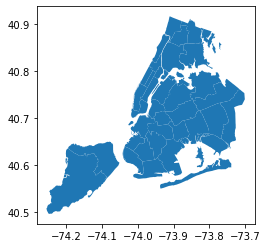

In [8]:
# plot all geometry polygons
ngbhoods.geometry.plot();

In [9]:
# turn taxi_df into geodataframe
taxi_gdf = gpd.GeoDataFrame(
    df, crs="EPSG:4326",
    geometry=[Point(xy) for xy in
              zip(df['pickup_longitude'], df['pickup_latitude'])])

In [10]:
taxi_gdf.tail(3)

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,geometry
9997,VTS,2009-01-03 09:54:00,2009-01-03 10:17:00,2,9.06,-73.873022,40.774053,NaN,NaN,-73.971993,40.796870,CASH,24.1,0.0,NaN,0.0,4.15,28.25,POINT (-73.87302 40.77405)
9998,VTS,2009-01-07 19:56:00,2009-01-07 20:04:00,1,3.02,-73.984955,40.756653,NaN,NaN,-73.997372,40.721703,Credit,11.3,1.0,NaN,2.0,0.00,14.30,POINT (-73.98495 40.75665)
9999,VTS,2009-01-03 21:19:00,2009-01-03 21:29:00,2,2.29,-73.982615,40.782477,NaN,NaN,-73.953612,40.786927,CASH,8.5,0.5,NaN,0.0,0.00,9.00,POINT (-73.98261 40.78248)


In [11]:
# drop lat/long columns
taxi_gdf = taxi_gdf.drop(
    columns= [
        'pickup_longitude', 
        'pickup_latitude', 
        'dropoff_longitude', 
        'dropoff_latitude',
        'vendor_id',
        'rate_code',
        'store_and_fwd_flag',
        'mta_tax',
    ])
taxi_gdf.tail(3)

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,payment_type,fare_amount,surcharge,tip_amount,tolls_amount,total_amount,geometry
9997,2009-01-03 09:54:00,2009-01-03 10:17:00,2,9.06,CASH,24.1,0.0,0.0,4.15,28.25,POINT (-73.87302 40.77405)
9998,2009-01-07 19:56:00,2009-01-07 20:04:00,1,3.02,Credit,11.3,1.0,2.0,0.00,14.30,POINT (-73.98495 40.75665)
9999,2009-01-03 21:19:00,2009-01-03 21:29:00,2,2.29,CASH,8.5,0.5,0.0,0.00,9.00,POINT (-73.98261 40.78248)


Now that both of your datasets have geometry columns you can perform a spatial join.

Perform a left spatial join with taxi_gdf as the left_df and nghboohds as the right_df. Setting the predicate keyword to 'within' will join points in the left_df to polygons from the right_df they are located within:

In [12]:
%%time
# perform spatial join
joined = gpd.sjoin(
    taxi_gdf, 
    ngbhoods, 
    how='left',
    predicate="within",
)

CPU times: user 28 ms, sys: 3.36 ms, total: 31.3 ms
Wall time: 28.7 ms


In [13]:
# drop index column
joined = joined.drop(columns=['index_right'])

# rename columns
joined.rename(columns={'FIRST_UHF_': 'pickup_ngbhood_name', 'UHF_CODE': 'pickup_ngbhood_id'}, inplace=True)
joined.head(3)

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,payment_type,fare_amount,surcharge,tip_amount,tolls_amount,total_amount,geometry,pickup_ngbhood_name,pickup_ngbhood_id
0,2009-01-04 02:52:00,2009-01-04 03:02:00,1,2.63,CASH,8.9,0.5,0.00,0.0,9.40,POINT (-73.99196 40.72157),"Union Square, Lower Manhattan",309310.0
1,2009-01-04 03:31:00,2009-01-04 03:38:00,3,4.55,Credit,12.1,0.5,2.00,0.0,14.60,POINT (-73.98210 40.73629),Upper East Side - Gramercy,305307.0
2,2009-01-03 15:43:00,2009-01-03 15:57:00,5,10.35,Credit,23.7,0.0,4.74,0.0,28.44,POINT (-74.00259 40.73975),Chelsea - Village,306308.0


Now that you've performed the spatial join, you can analyse spatial patterns in the data.

For example, you can run a groupby that aggregates the mean trip_distance per pickup neighborhood:

In [14]:
res = joined.groupby('pickup_ngbhood_name').trip_distance.mean()
res

pickup_ngbhood_name
Bayside - Meadows                       2.830000
Bedford Stuyvesant - Crown Heights      2.758000
Bensonhurst - Bay Ridge                 1.185000
Borough Park                            3.678000
Canarsie - Flatlands                    0.430000
Central Harlem - Morningside Heights    2.694284
Chelsea - Village                       2.298598
Coney Island - Sheepshead Bay           3.155000
Downtown  - Heights - Slope             3.824302
East Flatbush - Flatbush                3.247143
East Harlem                             2.379284
Flushing - Clearview                    2.272000
Greenpoint                              2.910851
Jamaica                                 2.567500
Kingsbridge - Riverdale                 9.490000
Long Island City - Astoria              3.540909
Pelham - Throgs Neck                    1.670000
Ridgewood - Forest Hills                2.739187
South Bronx                             1.007778
Southeast Queens                        9.580000


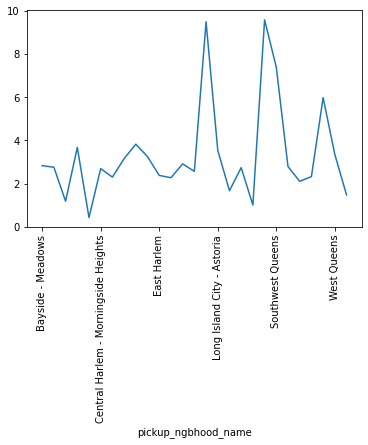

In [15]:
res.plot(rot=90);

Clearly, trips started in Southern Queens neighbourhoods are the longest distances.

## Spatial Join: Spatialpandas
Some amazing text goes here...

### Option 1: Read Shapefile into Spatialpandas

In [ ]:
ngbhoods_sp = spatialpandas.from_

### Option 2: Convert GeoPandas into Spatialpandas 

In [16]:
from spatialpandas import GeoDataFrame, GeoSeries

In [17]:
ngbhoods_sp = GeoDataFrame(ngbhoods)
ngbhoods_sp.head(3)

/Users/rpelgrim/mambaforge/envs/dask-dataframe/lib/python3.9/site-packages/spatialpandas/geometry/polygon.py:41: ShapelyDeprecationWarning: Accessing the 'ctypes' attribute is deprecated, and will not be possible any more in Shapely 2.0
  exterior = np.asarray(shape.exterior.ctypes)
/Users/rpelgrim/mambaforge/envs/dask-dataframe/lib/python3.9/site-packages/spatialpandas/geometry/multipolygon.py:42: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in shape:


,geometry,FIRST_UHF_,UHF_CODE
0,"MultiPolygon([[[-73.8779313565267, 40.90556327...",Kingsbridge - Riverdale,101.0
1,"MultiPolygon([[[-73.85252590936993, 40.9098462...",Northeast Bronx,102.0
2,"MultiPolygon([[[-73.85626847312932, 40.8831498...",Fordham - Bronx Park,103.0


In [18]:
type(ngbhoods_sp)

spatialpandas.geodataframe.GeoDataFrame

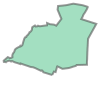

In [19]:
ngbhoods_sp.geometry[2].to_shapely()

### Convert Taxi Data to Spatialpandas Geometry

In [20]:
from spatialpandas.geometry import (
    LineArray,
    MultiLineArray,
    MultiPointArray,
    MultiPolygonArray,
    PointArray,
    PolygonArray,
)

Spatialpandas works slightly differently. It is more flexible and allows you to construct different kinds of geometries.

We'll create Point Arrays from the pickup longitude and latitude columns and then add that PointArray column to our df:

In [21]:
# turn pickup lat/long into spatialpandas geometry
pickups = df[["pickup_longitude", "pickup_latitude"]]
pickup_points = PointArray(pickups)
pickup_points

<PointArray>
[        Point([-73.991957, 40.721567]),
          Point([-73.982102, 40.73629]),
         Point([-74.002587, 40.739748]),
         Point([-73.974267, 40.790955]),
          Point([-74.00158, 40.719382]),
         Point([-73.989806, 40.735006]),
 Point([-73.98404999999998, 40.743544]),
         Point([-73.992635, 40.748362]),
          Point([-73.96969, 40.749244]),
         Point([-73.955173, 40.783044]),
 ...
 Point([-74.00325999999998, 40.727372]),
         Point([-73.988977, 40.726738]),
 Point([-73.98133699999998, 40.742982]),
         Point([-73.993633, 40.751902]),
  Point([-73.95345299999998, 40.78236]),
         Point([-73.997167, 40.737425]),
 Point([-73.96221199999998, 40.779117]),
         Point([-73.873022, 40.774053]),
         Point([-73.984955, 40.756653]),
 Point([-73.98261499999998, 40.782477])]
Length: 10000, dtype: point[float64]

In [22]:
# create GeoDataFrame from PointArray
taxi_gdf_sp = GeoDataFrame(
    {
        "pickup_geo": pickup_points,
    }
)

In [23]:
# drop numeric geo data from df
df2 = df.drop(
    columns=["dropoff_longitude", "dropoff_latitude", "pickup_longitude", "pickup_latitude"],
)

In [24]:
# join dataframes
taxi_gdf_sp = taxi_gdf_sp.merge(
    df2,
    how="left",
    left_index=True,
    right_index=True,
)

/Users/rpelgrim/mambaforge/envs/dask-dataframe/lib/python3.9/site-packages/spatialpandas/geometry/point.py:31: ShapelyDeprecationWarning: Accessing the 'ctypes' attribute is deprecated, and will not be possible any more in Shapely 2.0
  return np.asarray(shape.ctypes)


In [25]:
taxi_gdf_sp.head(3)

,pickup_geo,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,geometry
0,"Point([-73.991957, 40.721567])",VTS,2009-01-04 02:52:00,2009-01-04 03:02:00,1,2.63,NaN,NaN,CASH,8.9,0.5,NaN,0.00,0.0,9.40,"Point([-73.991957, 40.721567])"
1,"Point([-73.982102, 40.73629])",VTS,2009-01-04 03:31:00,2009-01-04 03:38:00,3,4.55,NaN,NaN,Credit,12.1,0.5,NaN,2.00,0.0,14.60,"Point([-73.982102, 40.73629])"
2,"Point([-74.002587, 40.739748])",VTS,2009-01-03 15:43:00,2009-01-03 15:57:00,5,10.35,NaN,NaN,Credit,23.7,0.0,NaN,4.74,0.0,28.44,"Point([-74.002587, 40.739748])"


Now we're ready to perform our spatial join:

In [26]:
from spatialpandas import sjoin

In [27]:
%%time
# execute spatial join
joined_sp = sjoin(
    taxi_gdf_sp, 
    ngbhoods_sp, 
    how='left',
    op='intersects',
)

CPU times: user 3.53 s, sys: 140 ms, total: 3.67 s
Wall time: 3.42 s


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [78]:
joined_sp

,pickup_geo,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,geometry,index_right,FIRST_UHF_,UHF_CODE
0,"Point([-73.991957, 40.721567])",VTS,2009-01-04 02:52:00,2009-01-04 03:02:00,1,2.63,NaN,NaN,CASH,8.9,0.5,NaN,0.00,0.00,9.40,"Point([-73.991957, 40.721567])",29.0,"Union Square, Lower Manhattan",309310.0
1,"Point([-73.982102, 40.73629])",VTS,2009-01-04 03:31:00,2009-01-04 03:38:00,3,4.55,NaN,NaN,Credit,12.1,0.5,NaN,2.00,0.00,14.60,"Point([-73.982102, 40.73629])",27.0,Upper East Side - Gramercy,305307.0
2,"Point([-74.002587, 40.739748])",VTS,2009-01-03 15:43:00,2009-01-03 15:57:00,5,10.35,NaN,NaN,Credit,23.7,0.0,NaN,4.74,0.00,28.44,"Point([-74.002587, 40.739748])",28.0,Chelsea - Village,306308.0
3,"Point([-73.974267, 40.790955])",DDS,2009-01-01 20:52:58,2009-01-01 21:14:00,1,5.00,NaN,NaN,CREDIT,14.9,0.5,NaN,3.05,0.00,18.45,"Point([-73.974267, 40.790955])",18.0,Upper West Side,304.0
4,"Point([-74.00158, 40.719382])",DDS,2009-01-24 16:18:23,2009-01-24 16:24:56,1,0.40,NaN,NaN,CASH,3.7,0.0,NaN,0.00,0.00,3.70,"Point([-74.00158, 40.719382])",28.0,Chelsea - Village,306308.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,"Point([-73.997167, 40.737425])",VTS,2009-01-03 21:33:00,2009-01-03 21:39:00,1,1.10,NaN,NaN,CASH,5.3,0.5,NaN,0.00,0.00,5.80,"Point([-73.997167, 40.737425])",28.0,Chelsea - Village,306308.0
9996,"Point([-73.96221199999998, 40.779117])",VTS,2009-01-03 19:04:00,2009-01-03 19:19:00,5,2.64,NaN,NaN,CASH,10.1,0.0,NaN,0.00,0.00,10.10,"Point([-73.96221199999998, 40.779117])",34.0,None,0.0
9997,"Point([-73.873022, 40.774053])",VTS,2009-01-03 09:54:00,2009-01-03 10:17:00,2,9.06,NaN,NaN,CASH,24.1,0.0,NaN,0.00,4.15,28.25,"Point([-73.873022, 40.774053])",34.0,None,0.0
9998,"Point([-73.984955, 40.756653])",VTS,2009-01-07 19:56:00,2009-01-07 20:04:00,1,3.02,NaN,NaN,Credit,11.3,1.0,NaN,2.00,0.00,14.30,"Point([-73.984955, 40.756653])",28.0,Chelsea - Village,306308.0


In [81]:
joined_sp

,pickup_geo,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,geometry,index_right,FIRST_UHF_,UHF_CODE
0,"Point([-73.991957, 40.721567])",VTS,2009-01-04 02:52:00,2009-01-04 03:02:00,1,2.63,NaN,NaN,CASH,8.9,0.5,NaN,0.00,0.00,9.40,"Point([-73.991957, 40.721567])",29.0,"Union Square, Lower Manhattan",309310.0
1,"Point([-73.982102, 40.73629])",VTS,2009-01-04 03:31:00,2009-01-04 03:38:00,3,4.55,NaN,NaN,Credit,12.1,0.5,NaN,2.00,0.00,14.60,"Point([-73.982102, 40.73629])",27.0,Upper East Side - Gramercy,305307.0
2,"Point([-74.002587, 40.739748])",VTS,2009-01-03 15:43:00,2009-01-03 15:57:00,5,10.35,NaN,NaN,Credit,23.7,0.0,NaN,4.74,0.00,28.44,"Point([-74.002587, 40.739748])",28.0,Chelsea - Village,306308.0
3,"Point([-73.974267, 40.790955])",DDS,2009-01-01 20:52:58,2009-01-01 21:14:00,1,5.00,NaN,NaN,CREDIT,14.9,0.5,NaN,3.05,0.00,18.45,"Point([-73.974267, 40.790955])",18.0,Upper West Side,304.0
4,"Point([-74.00158, 40.719382])",DDS,2009-01-24 16:18:23,2009-01-24 16:24:56,1,0.40,NaN,NaN,CASH,3.7,0.0,NaN,0.00,0.00,3.70,"Point([-74.00158, 40.719382])",28.0,Chelsea - Village,306308.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,"Point([-73.997167, 40.737425])",VTS,2009-01-03 21:33:00,2009-01-03 21:39:00,1,1.10,NaN,NaN,CASH,5.3,0.5,NaN,0.00,0.00,5.80,"Point([-73.997167, 40.737425])",28.0,Chelsea - Village,306308.0
9996,"Point([-73.96221199999998, 40.779117])",VTS,2009-01-03 19:04:00,2009-01-03 19:19:00,5,2.64,NaN,NaN,CASH,10.1,0.0,NaN,0.00,0.00,10.10,"Point([-73.96221199999998, 40.779117])",34.0,None,0.0
9997,"Point([-73.873022, 40.774053])",VTS,2009-01-03 09:54:00,2009-01-03 10:17:00,2,9.06,NaN,NaN,CASH,24.1,0.0,NaN,0.00,4.15,28.25,"Point([-73.873022, 40.774053])",34.0,None,0.0
9998,"Point([-73.984955, 40.756653])",VTS,2009-01-07 19:56:00,2009-01-07 20:04:00,1,3.02,NaN,NaN,Credit,11.3,1.0,NaN,2.00,0.00,14.30,"Point([-73.984955, 40.756653])",28.0,Chelsea - Village,306308.0


Looks like this worked.

Geopandas was faster and required less steps. When working with datasets that are small enough to fit into memory (pandas DataFrames), generally use GeoPandas. Unless you need some of the specific functionality of spatialpandas.

## Spatial Join: at scale with Dask-Geopandas
We're going to be working at scale now with the data for the five-year period from 2009-2013. This data totals ~120GB on disk. We'll need some extra computing power to run this analysis. Let's scale out to a Dask cluster with Coiled:

In [ ]:
# cluster = Cluster(
#     software="coiled-examples/spatial-join",
# )